# training with out viewing dataset

In [13]:
import pandas as pd

In [14]:
train = pd.read_excel('./data/Andhrapradesh/chittoor_data.xls')

In [15]:
train

,Unnamed: 0,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha
0,0,grape,1993,6000,1200000,18432
1,1,rice,1978,6300000,73352000,19623
2,2,barley,1985,70000,104225008,258628
3,3,tomato,1963,434000,24734608,343061
4,4,pineapple,1998,12572000,246806,137248
...,...,...,...,...,...,...
653,653,green_pea,1988,9822,1900000,10000
654,654,sugarcane,2006,849000,478271,16094
655,655,rice,2001,5797200,24104400,222274
656,656,papaya,1973,962200,203036800,10699


In [4]:
print("Unique Crops: ", len(train.Crop.unique()))
print("Avg. number of datas for each crop: ", 658/14)

Unique Crops:  14
Avg. number of datas for each crop:  47.0


In [5]:
df = train.drop('Unnamed: 0',axis =1)
df["kfold"] = -1


In [6]:
import numpy as np
import pandas as pd
from sklearn import model_selection
df

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold
0,grape,1993,6000,1200000,18432,-1
1,rice,1978,6300000,73352000,19623,-1
2,barley,1985,70000,104225008,258628,-1
3,tomato,1963,434000,24734608,343061,-1
4,pineapple,1998,12572000,246806,137248,-1
...,...,...,...,...,...,...
653,green_pea,1988,9822,1900000,10000,-1
654,sugarcane,2006,849000,478271,16094,-1
655,rice,2001,5797200,24104400,222274,-1
656,papaya,1973,962200,203036800,10699,-1


In [7]:
df = train.drop('Unnamed: 0',axis =1)
df["kfold"] = -1
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df)):
    df.loc[valid_indicies, "kfold"] = fold

In [8]:
df.head()

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold
0,grape,1993,6000,1200000,18432,1
1,rice,1978,6300000,73352000,19623,4
2,barley,1985,70000,104225008,258628,0
3,tomato,1963,434000,24734608,343061,2
4,pineapple,1998,12572000,246806,137248,4


In [9]:
from sklearn.model_selection import train_test_split

train, df_test = train_test_split(df, test_size=0.2)


In [10]:
train.head()

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold
277,tomato,1970,224500,110001008,200541,0
519,maize,2000,3205000,1564700,16058,3
472,ginger,1964,83490,750000,97222,3
386,banana,1970,5915100,643100,87500,3
317,green_pea,2004,1249000,156120,9167,3


In [11]:
df = train

In [17]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna

## using optuna for hyper parameter tuning

## using k fold method


In [18]:


useful_features = [c for c in df.columns if c not in ("id", "Production Quantity - tonnes", "kfold")]
object_cols = [col for col in useful_features if col.startswith("Cro")]
df_test = df_test[useful_features]

for col in object_cols:
    temp_df = []
    temp_test_feat = None
    for fold in range(5):
        xtrain =  df[df.kfold != fold].reset_index(drop=True)
        xvalid = df[df.kfold == fold].reset_index(drop=True)
        feat = xtrain.groupby(col)["Production Quantity - tonnes"].agg("mean")
        feat = feat.to_dict()
        xvalid.loc[:, f"tar_enc_{col}"] = xvalid[col].map(feat)
        temp_df.append(xvalid)
        if temp_test_feat is None:
            temp_test_feat = df_test[col].map(feat)
        else:
            temp_test_feat += df_test[col].map(feat)
    
    temp_test_feat /= 5
    df_test.loc[:, f"tar_enc_{col}"] = temp_test_feat
    df = pd.concat(temp_df)
    


In [19]:
useful_features = [c for c in df.columns if c not in ("id", "Production Quantity - tonnes", "kfold")]
object_cols = [col for col in useful_features if col.startswith("Cro")]
numerical_cols = [col for col in useful_features if not (col.startswith("Cro"))]

df_test = df_test[useful_features]


# usibg ordinal encoder

In [20]:
def run(trial):
    fold = 0
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)

    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)

    ytrain = xtrain['Production Quantity - tonnes']
    yvalid = xvalid['Production Quantity - tonnes']

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])

    model = XGBRegressor(
        random_state=42,
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=1000)
    preds_valid = model.predict(xvalid)
    rmse = mean_squared_error(yvalid, preds_valid, squared=False)
    return rmse

In [21]:
study = optuna.create_study(direction="minimize")
study.optimize(run, n_trials=15)

[I 2021-09-24 18:57:38,200] A new study created in memory with name: no-name-d37107d4-6a1d-45e2-b35f-bcc54a70d7e1


[0]	validation_0-rmse:63634516.00000
[1000]	validation_0-rmse:57286572.00000
[2000]	validation_0-rmse:58338948.00000
[3000]	validation_0-rmse:59143668.00000
[4000]	validation_0-rmse:59343932.00000
[5000]	validation_0-rmse:59660984.00000
[6000]	validation_0-rmse:59790120.00000
[6999]	validation_0-rmse:59908208.00000


[I 2021-09-24 18:57:44,676] Trial 0 finished with value: 59908206.487769246 and parameters: {'learning_rate': 0.011475557230675117, 'reg_lambda': 0.21668671336310583, 'reg_alpha': 0.13156936824986623, 'subsample': 0.7006971547202588, 'colsample_bytree': 0.9442833825500442, 'max_depth': 3}. Best is trial 0 with value: 59908206.487769246.


[0]	validation_0-rmse:63525552.00000
[1000]	validation_0-rmse:57760672.00000
[2000]	validation_0-rmse:57664748.00000
[3000]	validation_0-rmse:57691560.00000
[4000]	validation_0-rmse:57688672.00000
[5000]	validation_0-rmse:57688080.00000
[6000]	validation_0-rmse:57688040.00000
[6999]	validation_0-rmse:57688060.00000


[I 2021-09-24 18:57:53,768] Trial 1 finished with value: 57688060.5020693 and parameters: {'learning_rate': 0.01696701569191739, 'reg_lambda': 3.937364058614218e-07, 'reg_alpha': 1.9503989415937797, 'subsample': 0.4346335443389969, 'colsample_bytree': 0.8145867288752338, 'max_depth': 6}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:60375516.00000
[1000]	validation_0-rmse:60481236.00000
[2000]	validation_0-rmse:61456892.00000
[3000]	validation_0-rmse:61578392.00000
[4000]	validation_0-rmse:61626584.00000
[5000]	validation_0-rmse:61632092.00000
[6000]	validation_0-rmse:61637940.00000
[6999]	validation_0-rmse:61639868.00000


[I 2021-09-24 18:57:58,294] Trial 2 finished with value: 61639870.824231826 and parameters: {'learning_rate': 0.16753240346839143, 'reg_lambda': 0.017088576517766994, 'reg_alpha': 1.2312432996830011e-05, 'subsample': 0.8890514567354394, 'colsample_bytree': 0.782592782977793, 'max_depth': 2}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:62996964.00000
[1000]	validation_0-rmse:61500072.00000
[2000]	validation_0-rmse:61728688.00000
[3000]	validation_0-rmse:61684200.00000
[4000]	validation_0-rmse:61675132.00000
[5000]	validation_0-rmse:61672844.00000
[6000]	validation_0-rmse:61672136.00000
[6999]	validation_0-rmse:61671988.00000


[I 2021-09-24 18:58:05,910] Trial 3 finished with value: 61671987.097613126 and parameters: {'learning_rate': 0.1086909500837267, 'reg_lambda': 20.28280792655185, 'reg_alpha': 8.935060995877408e-06, 'subsample': 0.3298778404217916, 'colsample_bytree': 0.8142373225449812, 'max_depth': 6}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:62770564.00000
[1000]	validation_0-rmse:59861128.00000
[2000]	validation_0-rmse:59903792.00000
[3000]	validation_0-rmse:59904180.00000
[4000]	validation_0-rmse:59904332.00000
[5000]	validation_0-rmse:59904368.00000
[6000]	validation_0-rmse:59904376.00000
[6999]	validation_0-rmse:59904384.00000


[I 2021-09-24 18:58:11,290] Trial 4 finished with value: 59904382.73339664 and parameters: {'learning_rate': 0.0924440327450672, 'reg_lambda': 0.07720258096532721, 'reg_alpha': 0.5861605779057618, 'subsample': 0.7205392202425634, 'colsample_bytree': 0.42020621386368995, 'max_depth': 4}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:63483376.00000
[1000]	validation_0-rmse:56200680.00000
[2000]	validation_0-rmse:56693452.00000
[3000]	validation_0-rmse:56978100.00000
[4000]	validation_0-rmse:57291108.00000
[5000]	validation_0-rmse:57778100.00000
[6000]	validation_0-rmse:57998204.00000
[6999]	validation_0-rmse:58427516.00000


[I 2021-09-24 18:58:15,099] Trial 5 finished with value: 58427515.14090674 and parameters: {'learning_rate': 0.03019191152767971, 'reg_lambda': 0.05638894484312818, 'reg_alpha': 1.5611139628619917, 'subsample': 0.907046650570386, 'colsample_bytree': 0.5633222274639088, 'max_depth': 1}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:61707048.00000
[1000]	validation_0-rmse:66916924.00000
[2000]	validation_0-rmse:66879244.00000
[3000]	validation_0-rmse:66877592.00000
[4000]	validation_0-rmse:66877608.00000
[5000]	validation_0-rmse:66877628.00000
[6000]	validation_0-rmse:66877648.00000
[6999]	validation_0-rmse:66877660.00000


[I 2021-09-24 18:58:21,692] Trial 6 finished with value: 66877657.6581978 and parameters: {'learning_rate': 0.1078270987722645, 'reg_lambda': 0.0010299845158149427, 'reg_alpha': 2.816300080126254, 'subsample': 0.27155462734498437, 'colsample_bytree': 0.5772857838870046, 'max_depth': 5}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:63415232.00000
[1000]	validation_0-rmse:57280108.00000
[2000]	validation_0-rmse:58839944.00000
[3000]	validation_0-rmse:59570592.00000
[4000]	validation_0-rmse:59784696.00000
[5000]	validation_0-rmse:60007292.00000
[6000]	validation_0-rmse:60076000.00000
[6999]	validation_0-rmse:60273804.00000


[I 2021-09-24 18:58:25,862] Trial 7 finished with value: 60273803.3909851 and parameters: {'learning_rate': 0.027993045715379118, 'reg_lambda': 3.3076377498173874e-05, 'reg_alpha': 1.981126298023002e-08, 'subsample': 0.9738251272699078, 'colsample_bytree': 0.907070906696082, 'max_depth': 2}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:61857972.00000
[1000]	validation_0-rmse:63540212.00000
[2000]	validation_0-rmse:63529760.00000
[3000]	validation_0-rmse:63530636.00000
[4000]	validation_0-rmse:63530700.00000
[5000]	validation_0-rmse:63530712.00000
[6000]	validation_0-rmse:63530732.00000
[6999]	validation_0-rmse:63530756.00000


[I 2021-09-24 18:58:30,731] Trial 8 finished with value: 63530756.12050341 and parameters: {'learning_rate': 0.24903485050326624, 'reg_lambda': 0.2582195970435307, 'reg_alpha': 0.007941792971749444, 'subsample': 0.6964051259801141, 'colsample_bytree': 0.586166797317612, 'max_depth': 3}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:63667680.00000
[1000]	validation_0-rmse:62758224.00000
[2000]	validation_0-rmse:64595444.00000
[3000]	validation_0-rmse:65320532.00000
[4000]	validation_0-rmse:65705216.00000
[5000]	validation_0-rmse:65938336.00000
[6000]	validation_0-rmse:66058068.00000
[6999]	validation_0-rmse:66152612.00000


[I 2021-09-24 18:58:38,297] Trial 9 finished with value: 66152611.76164784 and parameters: {'learning_rate': 0.01707732278357159, 'reg_lambda': 0.0006009679434272815, 'reg_alpha': 1.8054204457413653e-08, 'subsample': 0.7299124284865193, 'colsample_bytree': 0.3173782444772495, 'max_depth': 7}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:63442100.00000
[1000]	validation_0-rmse:69422784.00000
[2000]	validation_0-rmse:70995576.00000
[3000]	validation_0-rmse:71447808.00000
[4000]	validation_0-rmse:71546488.00000
[5000]	validation_0-rmse:71580064.00000
[6000]	validation_0-rmse:71588688.00000
[6999]	validation_0-rmse:71591736.00000


[I 2021-09-24 18:58:45,981] Trial 10 finished with value: 71591736.54751502 and parameters: {'learning_rate': 0.04697310743224723, 'reg_lambda': 1.8239113841736247e-08, 'reg_alpha': 54.21124220433481, 'subsample': 0.45198392358245615, 'colsample_bytree': 0.20503057235972866, 'max_depth': 7}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:63515288.00000
[1000]	validation_0-rmse:56062764.00000
[2000]	validation_0-rmse:57579224.00000
[3000]	validation_0-rmse:58642116.00000
[4000]	validation_0-rmse:58731916.00000
[5000]	validation_0-rmse:59549224.00000
[6000]	validation_0-rmse:59704428.00000
[6999]	validation_0-rmse:60356064.00000


[I 2021-09-24 18:58:49,581] Trial 11 finished with value: 60356065.97029077 and parameters: {'learning_rate': 0.028617473392035343, 'reg_lambda': 2.6438711600551987e-07, 'reg_alpha': 75.25267780738349, 'subsample': 0.48554856004459807, 'colsample_bytree': 0.6946960302559786, 'max_depth': 1}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:63686704.00000
[1000]	validation_0-rmse:61493532.00000
[2000]	validation_0-rmse:61713992.00000
[3000]	validation_0-rmse:61823516.00000
[4000]	validation_0-rmse:61838408.00000
[5000]	validation_0-rmse:61843564.00000
[6000]	validation_0-rmse:61845500.00000
[6999]	validation_0-rmse:61845980.00000


[I 2021-09-24 18:58:56,498] Trial 12 finished with value: 61845977.104411505 and parameters: {'learning_rate': 0.023413349184358192, 'reg_lambda': 3.4442425563177896e-06, 'reg_alpha': 0.003963011773185131, 'subsample': 0.5821226333238244, 'colsample_bytree': 0.44440592809774515, 'max_depth': 5}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:63782192.00000
[1000]	validation_0-rmse:55068544.00000
[2000]	validation_0-rmse:55314392.00000
[3000]	validation_0-rmse:56309556.00000
[4000]	validation_0-rmse:56773140.00000
[5000]	validation_0-rmse:57007300.00000
[6000]	validation_0-rmse:57680908.00000
[6999]	validation_0-rmse:58343156.00000


[I 2021-09-24 18:59:00,202] Trial 13 finished with value: 58343156.906103775 and parameters: {'learning_rate': 0.010083988995525962, 'reg_lambda': 6.302940024742088, 'reg_alpha': 0.046015341501022974, 'subsample': 0.13824233923907153, 'colsample_bytree': 0.6387593660078521, 'max_depth': 1}. Best is trial 1 with value: 57688060.5020693.


[0]	validation_0-rmse:63843316.00000
[1000]	validation_0-rmse:58405256.00000
[2000]	validation_0-rmse:58410796.00000
[3000]	validation_0-rmse:58615344.00000
[4000]	validation_0-rmse:58593828.00000
[5000]	validation_0-rmse:58551608.00000
[6000]	validation_0-rmse:58438236.00000
[6999]	validation_0-rmse:58431816.00000


[I 2021-09-24 18:59:06,050] Trial 14 finished with value: 58431818.62122145 and parameters: {'learning_rate': 0.010242075435520439, 'reg_lambda': 75.07014533408987, 'reg_alpha': 9.047192304845467e-05, 'subsample': 0.1219400211495359, 'colsample_bytree': 0.7447781278505398, 'max_depth': 5}. Best is trial 1 with value: 57688060.5020693.


## Best is trial 1 with RMSE value: 57688060.5020693.

In [22]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [23]:
numerical_cols = [col for col in useful_features if not (col.startswith("Cro"))]


In [24]:
def run(trial):
    fold = 0
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.35, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 9)

    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)

    ytrain = xtrain['Production Quantity - tonnes']
    yvalid = xvalid['Production Quantity - tonnes']

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
    scaler = preprocessing.StandardScaler()
    xtrain[numerical_cols] = scaler.fit_transform(xtrain[numerical_cols])
    xvalid[numerical_cols] = scaler.transform(xvalid[numerical_cols])

    model = XGBRegressor(
        random_state=42,
        n_estimators=15000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=1000)
    preds_valid = model.predict(xvalid)
    rmse = mean_squared_error(yvalid, preds_valid, squared=False)
    return rmse

In [25]:
study = optuna.create_study(direction="minimize")
study.optimize(run, n_trials=30)

[I 2021-09-24 19:00:30,124] A new study created in memory with name: no-name-220085ff-60ae-484e-b8f1-6dd3f577da63


[0]	validation_0-rmse:60871248.00000
[1000]	validation_0-rmse:66184012.00000
[2000]	validation_0-rmse:66184248.00000
[3000]	validation_0-rmse:66184264.00000
[4000]	validation_0-rmse:66184272.00000
[5000]	validation_0-rmse:66184272.00000
[6000]	validation_0-rmse:66184268.00000
[7000]	validation_0-rmse:66184260.00000
[8000]	validation_0-rmse:66184268.00000
[9000]	validation_0-rmse:66184272.00000
[10000]	validation_0-rmse:66184284.00000
[11000]	validation_0-rmse:66184284.00000
[12000]	validation_0-rmse:66184284.00000
[13000]	validation_0-rmse:66184300.00000
[14000]	validation_0-rmse:66184304.00000
[14999]	validation_0-rmse:66184312.00000


[I 2021-09-24 19:00:45,191] Trial 0 finished with value: 66184309.55599928 and parameters: {'learning_rate': 0.11406436822873009, 'reg_lambda': 1.4743120618251355e-07, 'reg_alpha': 8.449620432004545, 'subsample': 0.254976330497924, 'colsample_bytree': 0.8931064275160162, 'max_depth': 6}. Best is trial 0 with value: 66184309.55599928.


[0]	validation_0-rmse:63724000.00000
[1000]	validation_0-rmse:59695944.00000
[2000]	validation_0-rmse:62479816.00000
[3000]	validation_0-rmse:63887252.00000
[4000]	validation_0-rmse:64795812.00000
[5000]	validation_0-rmse:65512364.00000
[6000]	validation_0-rmse:66095212.00000
[7000]	validation_0-rmse:66622592.00000
[8000]	validation_0-rmse:67140832.00000
[9000]	validation_0-rmse:67515856.00000
[10000]	validation_0-rmse:67816480.00000
[11000]	validation_0-rmse:68143328.00000
[12000]	validation_0-rmse:68434200.00000
[13000]	validation_0-rmse:68658768.00000
[14000]	validation_0-rmse:68842504.00000
[14999]	validation_0-rmse:69034144.00000


[I 2021-09-24 19:01:00,754] Trial 1 finished with value: 69034147.67049763 and parameters: {'learning_rate': 0.015298592361360582, 'reg_lambda': 14.010395749790328, 'reg_alpha': 3.092886106089809e-08, 'subsample': 0.749116531835799, 'colsample_bytree': 0.39686296095851237, 'max_depth': 7}. Best is trial 0 with value: 66184309.55599928.


[0]	validation_0-rmse:63651392.00000
[1000]	validation_0-rmse:59462700.00000
[2000]	validation_0-rmse:60055988.00000
[3000]	validation_0-rmse:60697844.00000
[4000]	validation_0-rmse:60775124.00000
[5000]	validation_0-rmse:60879460.00000
[6000]	validation_0-rmse:60990120.00000
[7000]	validation_0-rmse:61016184.00000
[8000]	validation_0-rmse:61034524.00000
[9000]	validation_0-rmse:61044516.00000
[10000]	validation_0-rmse:61050068.00000
[11000]	validation_0-rmse:61051288.00000
[12000]	validation_0-rmse:61053200.00000
[13000]	validation_0-rmse:61054480.00000
[14000]	validation_0-rmse:61055348.00000
[14999]	validation_0-rmse:61055684.00000


[I 2021-09-24 19:01:14,069] Trial 2 finished with value: 61055681.62250305 and parameters: {'learning_rate': 0.022911690757317426, 'reg_lambda': 0.6664974734773871, 'reg_alpha': 0.0071249041036076785, 'subsample': 0.4480537284020849, 'colsample_bytree': 0.47338008359146067, 'max_depth': 4}. Best is trial 2 with value: 61055681.62250305.


[0]	validation_0-rmse:59436780.00000
[1000]	validation_0-rmse:70468664.00000
[2000]	validation_0-rmse:70465872.00000
[3000]	validation_0-rmse:70465872.00000
[4000]	validation_0-rmse:70465872.00000
[5000]	validation_0-rmse:70465872.00000
[6000]	validation_0-rmse:70465864.00000
[7000]	validation_0-rmse:70465864.00000
[8000]	validation_0-rmse:70465856.00000
[9000]	validation_0-rmse:70465856.00000
[10000]	validation_0-rmse:70465848.00000
[11000]	validation_0-rmse:70465848.00000
[12000]	validation_0-rmse:70465848.00000
[13000]	validation_0-rmse:70465840.00000
[14000]	validation_0-rmse:70465856.00000
[14999]	validation_0-rmse:70465856.00000


[I 2021-09-24 19:01:26,690] Trial 3 finished with value: 70465853.63555719 and parameters: {'learning_rate': 0.2637179284028474, 'reg_lambda': 0.000273514414147045, 'reg_alpha': 1.1546637713177466e-08, 'subsample': 0.34465521645606295, 'colsample_bytree': 0.683242948084351, 'max_depth': 4}. Best is trial 2 with value: 61055681.62250305.


[0]	validation_0-rmse:60863396.00000
[1000]	validation_0-rmse:78798440.00000
[2000]	validation_0-rmse:78841280.00000
[3000]	validation_0-rmse:78841256.00000
[4000]	validation_0-rmse:78841272.00000
[5000]	validation_0-rmse:78841296.00000
[6000]	validation_0-rmse:78841336.00000
[7000]	validation_0-rmse:78841352.00000
[8000]	validation_0-rmse:78841384.00000
[9000]	validation_0-rmse:78841432.00000
[10000]	validation_0-rmse:78841448.00000
[11000]	validation_0-rmse:78841480.00000
[12000]	validation_0-rmse:78841512.00000
[13000]	validation_0-rmse:78841520.00000
[14000]	validation_0-rmse:78841544.00000
[14999]	validation_0-rmse:78841568.00000


[I 2021-09-24 19:01:46,813] Trial 4 finished with value: 78841567.64429522 and parameters: {'learning_rate': 0.16037020693762685, 'reg_lambda': 0.008714746101405983, 'reg_alpha': 3.1247167013809435e-08, 'subsample': 0.13918164070087724, 'colsample_bytree': 0.7172225898548467, 'max_depth': 8}. Best is trial 2 with value: 61055681.62250305.


[0]	validation_0-rmse:60988816.00000
[1000]	validation_0-rmse:61397168.00000
[2000]	validation_0-rmse:63192452.00000
[3000]	validation_0-rmse:65273856.00000
[4000]	validation_0-rmse:66565112.00000
[5000]	validation_0-rmse:67744264.00000
[6000]	validation_0-rmse:68399304.00000
[7000]	validation_0-rmse:68791216.00000
[8000]	validation_0-rmse:69599712.00000
[9000]	validation_0-rmse:69891912.00000
[10000]	validation_0-rmse:70990376.00000
[11000]	validation_0-rmse:70200536.00000
[12000]	validation_0-rmse:70769256.00000
[13000]	validation_0-rmse:70669552.00000
[14000]	validation_0-rmse:70626880.00000
[14999]	validation_0-rmse:70770304.00000


[I 2021-09-24 19:01:55,140] Trial 5 finished with value: 70770304.22592096 and parameters: {'learning_rate': 0.2962246765069966, 'reg_lambda': 0.01978505335565181, 'reg_alpha': 0.03366839697859998, 'subsample': 0.6200756034889134, 'colsample_bytree': 0.6992352405131179, 'max_depth': 1}. Best is trial 2 with value: 61055681.62250305.


[0]	validation_0-rmse:63754328.00000
[1000]	validation_0-rmse:59672848.00000
[2000]	validation_0-rmse:59858568.00000
[3000]	validation_0-rmse:59878656.00000
[4000]	validation_0-rmse:59880020.00000
[5000]	validation_0-rmse:59881648.00000
[6000]	validation_0-rmse:59882272.00000
[7000]	validation_0-rmse:59882416.00000
[8000]	validation_0-rmse:59882460.00000
[9000]	validation_0-rmse:59882452.00000
[10000]	validation_0-rmse:59882464.00000
[11000]	validation_0-rmse:59882488.00000
[12000]	validation_0-rmse:59882516.00000
[13000]	validation_0-rmse:59882540.00000
[14000]	validation_0-rmse:59882568.00000
[14999]	validation_0-rmse:59882596.00000


[I 2021-09-24 19:02:13,974] Trial 6 finished with value: 59882597.04416153 and parameters: {'learning_rate': 0.014743497535660007, 'reg_lambda': 0.16801316670775135, 'reg_alpha': 0.005221182364520261, 'subsample': 0.8595305289748592, 'colsample_bytree': 0.46778852891474043, 'max_depth': 6}. Best is trial 6 with value: 59882597.04416153.


[0]	validation_0-rmse:62930876.00000
[1000]	validation_0-rmse:62890968.00000
[2000]	validation_0-rmse:64360940.00000
[3000]	validation_0-rmse:66504436.00000
[4000]	validation_0-rmse:67193984.00000
[5000]	validation_0-rmse:66905788.00000
[6000]	validation_0-rmse:66646412.00000
[7000]	validation_0-rmse:66481668.00000
[8000]	validation_0-rmse:67022264.00000
[9000]	validation_0-rmse:67553632.00000
[10000]	validation_0-rmse:67880144.00000
[11000]	validation_0-rmse:68388280.00000
[12000]	validation_0-rmse:68651304.00000
[13000]	validation_0-rmse:69036928.00000
[14000]	validation_0-rmse:69081128.00000
[14999]	validation_0-rmse:69087760.00000


[I 2021-09-24 19:02:23,912] Trial 7 finished with value: 69087758.71282555 and parameters: {'learning_rate': 0.05039119024742193, 'reg_lambda': 2.6400910837260363e-05, 'reg_alpha': 0.0031791730573513493, 'subsample': 0.15620016171553736, 'colsample_bytree': 0.6369288635024849, 'max_depth': 2}. Best is trial 6 with value: 59882597.04416153.


[0]	validation_0-rmse:59227032.00000
[1000]	validation_0-rmse:57736380.00000
[2000]	validation_0-rmse:57736412.00000
[3000]	validation_0-rmse:57736444.00000
[4000]	validation_0-rmse:57736436.00000
[5000]	validation_0-rmse:57736412.00000
[6000]	validation_0-rmse:57736392.00000
[7000]	validation_0-rmse:57736376.00000
[8000]	validation_0-rmse:57736364.00000
[9000]	validation_0-rmse:57736308.00000
[10000]	validation_0-rmse:57736256.00000
[11000]	validation_0-rmse:57736232.00000
[12000]	validation_0-rmse:57736216.00000
[13000]	validation_0-rmse:57736164.00000
[14000]	validation_0-rmse:57736124.00000
[14999]	validation_0-rmse:57736080.00000


[I 2021-09-24 19:02:56,723] Trial 8 finished with value: 57736082.7602614 and parameters: {'learning_rate': 0.27254954631877526, 'reg_lambda': 6.040631392110914e-06, 'reg_alpha': 0.14408311226623435, 'subsample': 0.9583587951827631, 'colsample_bytree': 0.7268162397255014, 'max_depth': 9}. Best is trial 8 with value: 57736082.7602614.


[0]	validation_0-rmse:63762568.00000
[1000]	validation_0-rmse:61916440.00000
[2000]	validation_0-rmse:64097500.00000
[3000]	validation_0-rmse:65452664.00000
[4000]	validation_0-rmse:66243968.00000
[5000]	validation_0-rmse:66814592.00000
[6000]	validation_0-rmse:67170088.00000
[7000]	validation_0-rmse:67440704.00000
[8000]	validation_0-rmse:67598056.00000
[9000]	validation_0-rmse:67731248.00000
[10000]	validation_0-rmse:67810336.00000
[11000]	validation_0-rmse:67876832.00000
[12000]	validation_0-rmse:67909352.00000
[13000]	validation_0-rmse:67975048.00000
[14000]	validation_0-rmse:67990144.00000
[14999]	validation_0-rmse:68026128.00000


[I 2021-09-24 19:03:12,017] Trial 9 finished with value: 68026135.46604487 and parameters: {'learning_rate': 0.011450528300384274, 'reg_lambda': 0.002103511425617403, 'reg_alpha': 6.064966369912953e-06, 'subsample': 0.4792188683033528, 'colsample_bytree': 0.21371723232930798, 'max_depth': 7}. Best is trial 8 with value: 57736082.7602614.


[0]	validation_0-rmse:62480340.00000
[1000]	validation_0-rmse:55590548.00000
[2000]	validation_0-rmse:55590564.00000
[3000]	validation_0-rmse:55590600.00000
[4000]	validation_0-rmse:55590612.00000
[5000]	validation_0-rmse:55590632.00000
[6000]	validation_0-rmse:55590628.00000
[7000]	validation_0-rmse:55590648.00000
[8000]	validation_0-rmse:55590588.00000
[9000]	validation_0-rmse:55590552.00000
[10000]	validation_0-rmse:55590536.00000
[11000]	validation_0-rmse:55590520.00000
[12000]	validation_0-rmse:55590468.00000
[13000]	validation_0-rmse:55590440.00000
[14000]	validation_0-rmse:55590416.00000
[14999]	validation_0-rmse:55590396.00000


[I 2021-09-24 19:03:35,102] Trial 10 finished with value: 55590391.390720725 and parameters: {'learning_rate': 0.06209225849874633, 'reg_lambda': 1.2637358295474018e-08, 'reg_alpha': 91.5235647978829, 'subsample': 0.9860444479863868, 'colsample_bytree': 0.9777947899850269, 'max_depth': 9}. Best is trial 10 with value: 55590391.390720725.


[0]	validation_0-rmse:62524780.00000
[1000]	validation_0-rmse:54865768.00000
[2000]	validation_0-rmse:54865756.00000
[3000]	validation_0-rmse:54865780.00000
[4000]	validation_0-rmse:54865792.00000
[5000]	validation_0-rmse:54865808.00000
[6000]	validation_0-rmse:54865800.00000
[7000]	validation_0-rmse:54865804.00000
[8000]	validation_0-rmse:54865836.00000
[9000]	validation_0-rmse:54865856.00000
[10000]	validation_0-rmse:54865812.00000
[11000]	validation_0-rmse:54865780.00000
[12000]	validation_0-rmse:54865744.00000
[13000]	validation_0-rmse:54865732.00000
[14000]	validation_0-rmse:54865708.00000
[14999]	validation_0-rmse:54865720.00000


[I 2021-09-24 19:04:01,882] Trial 11 finished with value: 54865718.27538277 and parameters: {'learning_rate': 0.06002486285620892, 'reg_lambda': 1.9812187353034692e-08, 'reg_alpha': 84.1776924236116, 'subsample': 0.9810527664418206, 'colsample_bytree': 0.9945226843956394, 'max_depth': 9}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:62720640.00000
[1000]	validation_0-rmse:57403156.00000
[2000]	validation_0-rmse:57403244.00000
[3000]	validation_0-rmse:57403340.00000
[4000]	validation_0-rmse:57403440.00000
[5000]	validation_0-rmse:57403568.00000
[6000]	validation_0-rmse:57403692.00000
[7000]	validation_0-rmse:57403800.00000
[8000]	validation_0-rmse:57403892.00000
[9000]	validation_0-rmse:57403980.00000
[10000]	validation_0-rmse:57404060.00000
[11000]	validation_0-rmse:57404160.00000
[12000]	validation_0-rmse:57404272.00000
[13000]	validation_0-rmse:57404384.00000
[14000]	validation_0-rmse:57404508.00000
[14999]	validation_0-rmse:57404596.00000


[I 2021-09-24 19:04:31,082] Trial 12 finished with value: 57404594.60359133 and parameters: {'learning_rate': 0.05101163383602175, 'reg_lambda': 2.583974336423819e-08, 'reg_alpha': 25.551710347107136, 'subsample': 0.986435320297871, 'colsample_bytree': 0.992383246952442, 'max_depth': 9}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:61279328.00000
[1000]	validation_0-rmse:57951856.00000
[2000]	validation_0-rmse:57951772.00000
[3000]	validation_0-rmse:57951680.00000
[4000]	validation_0-rmse:57951552.00000
[5000]	validation_0-rmse:57951432.00000
[6000]	validation_0-rmse:57951308.00000
[7000]	validation_0-rmse:57951160.00000
[8000]	validation_0-rmse:57951028.00000
[9000]	validation_0-rmse:57950904.00000
[10000]	validation_0-rmse:57950768.00000
[11000]	validation_0-rmse:57950644.00000
[12000]	validation_0-rmse:57950520.00000
[13000]	validation_0-rmse:57950364.00000
[14000]	validation_0-rmse:57950212.00000
[14999]	validation_0-rmse:57950088.00000


[I 2021-09-24 19:04:57,993] Trial 13 finished with value: 57950088.59015257 and parameters: {'learning_rate': 0.09319419331503646, 'reg_lambda': 4.5195749173009257e-07, 'reg_alpha': 1.3149084173256527, 'subsample': 0.7503026130055832, 'colsample_bytree': 0.8727663446671047, 'max_depth': 9}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:62888244.00000
[1000]	validation_0-rmse:57460768.00000
[2000]	validation_0-rmse:57460848.00000
[3000]	validation_0-rmse:57460844.00000
[4000]	validation_0-rmse:57460844.00000
[5000]	validation_0-rmse:57460832.00000
[6000]	validation_0-rmse:57460812.00000
[7000]	validation_0-rmse:57460780.00000
[8000]	validation_0-rmse:57460744.00000
[9000]	validation_0-rmse:57460712.00000
[10000]	validation_0-rmse:57460680.00000
[11000]	validation_0-rmse:57460660.00000
[12000]	validation_0-rmse:57460652.00000
[13000]	validation_0-rmse:57460640.00000
[14000]	validation_0-rmse:57460628.00000
[14999]	validation_0-rmse:57460640.00000


[I 2021-09-24 19:05:25,735] Trial 14 finished with value: 57460637.90923048 and parameters: {'learning_rate': 0.03578134862818129, 'reg_lambda': 1.645012775278581e-08, 'reg_alpha': 74.38691634712545, 'subsample': 0.8376992130991416, 'colsample_bytree': 0.9989274361774925, 'max_depth': 8}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:62739416.00000
[1000]	validation_0-rmse:61016028.00000
[2000]	validation_0-rmse:61016712.00000
[3000]	validation_0-rmse:61016708.00000
[4000]	validation_0-rmse:61016692.00000
[5000]	validation_0-rmse:61016688.00000
[6000]	validation_0-rmse:61016684.00000
[7000]	validation_0-rmse:61016680.00000
[8000]	validation_0-rmse:61016692.00000
[9000]	validation_0-rmse:61016692.00000
[10000]	validation_0-rmse:61016676.00000
[11000]	validation_0-rmse:61016664.00000
[12000]	validation_0-rmse:61016656.00000
[13000]	validation_0-rmse:61016656.00000
[14000]	validation_0-rmse:61016648.00000
[14999]	validation_0-rmse:61016652.00000


[I 2021-09-24 19:05:41,233] Trial 15 finished with value: 61016653.70922655 and parameters: {'learning_rate': 0.08880078686535825, 'reg_lambda': 3.319483204018596e-06, 'reg_alpha': 3.2037344590762505e-05, 'subsample': 0.647706580967859, 'colsample_bytree': 0.8355374216882426, 'max_depth': 5}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:62887244.00000
[1000]	validation_0-rmse:57020308.00000
[2000]	validation_0-rmse:57020500.00000
[3000]	validation_0-rmse:57020504.00000
[4000]	validation_0-rmse:57020468.00000
[5000]	validation_0-rmse:57020408.00000
[6000]	validation_0-rmse:57020376.00000
[7000]	validation_0-rmse:57020320.00000
[8000]	validation_0-rmse:57020260.00000
[9000]	validation_0-rmse:57020176.00000
[10000]	validation_0-rmse:57020080.00000
[11000]	validation_0-rmse:57019996.00000
[12000]	validation_0-rmse:57019900.00000
[13000]	validation_0-rmse:57019804.00000
[14000]	validation_0-rmse:57019736.00000
[14999]	validation_0-rmse:57019692.00000


[I 2021-09-24 19:06:05,929] Trial 16 finished with value: 57019691.13188762 and parameters: {'learning_rate': 0.030422908691804643, 'reg_lambda': 8.519349047328393e-05, 'reg_alpha': 0.8492385825847317, 'subsample': 0.8741983404332142, 'colsample_bytree': 0.8374277591648183, 'max_depth': 8}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:63039220.00000
[1000]	validation_0-rmse:65947768.00000
[2000]	validation_0-rmse:66457960.00000
[3000]	validation_0-rmse:66519400.00000
[4000]	validation_0-rmse:66531572.00000
[5000]	validation_0-rmse:66533664.00000
[6000]	validation_0-rmse:66534156.00000
[7000]	validation_0-rmse:66534204.00000
[8000]	validation_0-rmse:66534172.00000
[9000]	validation_0-rmse:66534144.00000
[10000]	validation_0-rmse:66534116.00000
[11000]	validation_0-rmse:66534072.00000
[12000]	validation_0-rmse:66534032.00000
[13000]	validation_0-rmse:66533992.00000
[14000]	validation_0-rmse:66533948.00000
[14999]	validation_0-rmse:66533900.00000


[I 2021-09-24 19:06:22,456] Trial 17 finished with value: 66533902.867095366 and parameters: {'learning_rate': 0.06971195499339487, 'reg_lambda': 5.156446879409226e-07, 'reg_alpha': 0.00017613030731184035, 'subsample': 0.7400711230912933, 'colsample_bytree': 0.12630373441486858, 'max_depth': 7}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:59780772.00000
[1000]	validation_0-rmse:61428648.00000
[2000]	validation_0-rmse:61437740.00000
[3000]	validation_0-rmse:61438128.00000
[4000]	validation_0-rmse:61438136.00000
[5000]	validation_0-rmse:61438136.00000
[6000]	validation_0-rmse:61438128.00000
[7000]	validation_0-rmse:61438124.00000
[8000]	validation_0-rmse:61438124.00000
[9000]	validation_0-rmse:61438116.00000
[10000]	validation_0-rmse:61438104.00000
[11000]	validation_0-rmse:61438096.00000
[12000]	validation_0-rmse:61438092.00000
[13000]	validation_0-rmse:61438084.00000
[14000]	validation_0-rmse:61438076.00000
[14999]	validation_0-rmse:61438072.00000


[I 2021-09-24 19:06:33,140] Trial 18 finished with value: 61438071.01846706 and parameters: {'learning_rate': 0.17594974540838898, 'reg_lambda': 2.8174975558609224e-08, 'reg_alpha': 2.320688198344116, 'subsample': 0.972546131476774, 'colsample_bytree': 0.918840109922601, 'max_depth': 3}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:63663004.00000
[1000]	validation_0-rmse:58959820.00000
[2000]	validation_0-rmse:58959856.00000
[3000]	validation_0-rmse:58959864.00000
[4000]	validation_0-rmse:58959856.00000
[5000]	validation_0-rmse:58959824.00000
[6000]	validation_0-rmse:58959808.00000
[7000]	validation_0-rmse:58959796.00000
[8000]	validation_0-rmse:58959768.00000
[9000]	validation_0-rmse:58959744.00000
[10000]	validation_0-rmse:58959736.00000
[11000]	validation_0-rmse:58959736.00000
[12000]	validation_0-rmse:58959712.00000
[13000]	validation_0-rmse:58959700.00000
[14000]	validation_0-rmse:58959696.00000
[14999]	validation_0-rmse:58959688.00000


[I 2021-09-24 19:06:58,514] Trial 19 finished with value: 58959686.8376517 and parameters: {'learning_rate': 0.036776038780801476, 'reg_lambda': 1.2501226693203155e-06, 'reg_alpha': 66.60945449714842, 'subsample': 0.6207336749560822, 'colsample_bytree': 0.7901194074150502, 'max_depth': 9}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:63237840.00000
[1000]	validation_0-rmse:60356844.00000
[2000]	validation_0-rmse:61031700.00000
[3000]	validation_0-rmse:61338732.00000
[4000]	validation_0-rmse:61476000.00000
[5000]	validation_0-rmse:61561336.00000
[6000]	validation_0-rmse:61605356.00000
[7000]	validation_0-rmse:61640204.00000
[8000]	validation_0-rmse:61657036.00000
[9000]	validation_0-rmse:61665588.00000
[10000]	validation_0-rmse:61668636.00000
[11000]	validation_0-rmse:61672668.00000
[12000]	validation_0-rmse:61675008.00000
[13000]	validation_0-rmse:61675720.00000
[14000]	validation_0-rmse:61676232.00000
[14999]	validation_0-rmse:61676684.00000


[I 2021-09-24 19:07:13,149] Trial 20 finished with value: 61676683.392741755 and parameters: {'learning_rate': 0.06347587199617483, 'reg_lambda': 57.91553092889665, 'reg_alpha': 0.18288818907069518, 'subsample': 0.8987063921658028, 'colsample_bytree': 0.5844100119757558, 'max_depth': 5}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:63153452.00000
[1000]	validation_0-rmse:57023852.00000
[2000]	validation_0-rmse:57024236.00000
[3000]	validation_0-rmse:57024284.00000
[4000]	validation_0-rmse:57024312.00000
[5000]	validation_0-rmse:57024348.00000
[6000]	validation_0-rmse:57024396.00000
[7000]	validation_0-rmse:57024432.00000
[8000]	validation_0-rmse:57024460.00000
[9000]	validation_0-rmse:57024464.00000
[10000]	validation_0-rmse:57024420.00000
[11000]	validation_0-rmse:57024384.00000
[12000]	validation_0-rmse:57024364.00000
[13000]	validation_0-rmse:57024320.00000
[14000]	validation_0-rmse:57024284.00000
[14999]	validation_0-rmse:57024272.00000


[I 2021-09-24 19:07:37,621] Trial 21 finished with value: 57024269.32247681 and parameters: {'learning_rate': 0.029318863530953195, 'reg_lambda': 7.339176793443866e-05, 'reg_alpha': 2.243566352580887, 'subsample': 0.8817954228300275, 'colsample_bytree': 0.941937847356592, 'max_depth': 8}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:63249280.00000
[1000]	validation_0-rmse:57534652.00000
[2000]	validation_0-rmse:57536952.00000
[3000]	validation_0-rmse:57536980.00000
[4000]	validation_0-rmse:57536976.00000
[5000]	validation_0-rmse:57536944.00000
[6000]	validation_0-rmse:57536932.00000
[7000]	validation_0-rmse:57536900.00000
[8000]	validation_0-rmse:57536872.00000
[9000]	validation_0-rmse:57536832.00000
[10000]	validation_0-rmse:57536796.00000
[11000]	validation_0-rmse:57536764.00000
[12000]	validation_0-rmse:57536728.00000
[13000]	validation_0-rmse:57536704.00000
[14000]	validation_0-rmse:57536672.00000
[14999]	validation_0-rmse:57536644.00000


[I 2021-09-24 19:08:02,534] Trial 22 finished with value: 57536643.244429834 and parameters: {'learning_rate': 0.023157584640473364, 'reg_lambda': 1.6034285606535744e-07, 'reg_alpha': 8.298590094275736, 'subsample': 0.8061844822511057, 'colsample_bytree': 0.8010564037276471, 'max_depth': 8}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:62900352.00000
[1000]	validation_0-rmse:57149540.00000
[2000]	validation_0-rmse:57149592.00000
[3000]	validation_0-rmse:57149608.00000
[4000]	validation_0-rmse:57149604.00000
[5000]	validation_0-rmse:57149604.00000
[6000]	validation_0-rmse:57149584.00000
[7000]	validation_0-rmse:57149576.00000
[8000]	validation_0-rmse:57149572.00000
[9000]	validation_0-rmse:57149580.00000
[10000]	validation_0-rmse:57149592.00000
[11000]	validation_0-rmse:57149632.00000
[12000]	validation_0-rmse:57149676.00000
[13000]	validation_0-rmse:57149692.00000
[14000]	validation_0-rmse:57149740.00000
[14999]	validation_0-rmse:57149796.00000


[I 2021-09-24 19:08:39,681] Trial 23 finished with value: 57149792.560652696 and parameters: {'learning_rate': 0.04284958248633818, 'reg_lambda': 3.1012054043097384e-05, 'reg_alpha': 0.37024876870563134, 'subsample': 0.986447620899942, 'colsample_bytree': 0.9954936372062311, 'max_depth': 9}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:63348516.00000
[1000]	validation_0-rmse:58052136.00000
[2000]	validation_0-rmse:58052776.00000
[3000]	validation_0-rmse:58052776.00000
[4000]	validation_0-rmse:58052808.00000
[5000]	validation_0-rmse:58052832.00000
[6000]	validation_0-rmse:58052876.00000
[7000]	validation_0-rmse:58052892.00000
[8000]	validation_0-rmse:58052876.00000
[9000]	validation_0-rmse:58052872.00000
[10000]	validation_0-rmse:58052864.00000
[11000]	validation_0-rmse:58052872.00000
[12000]	validation_0-rmse:58052848.00000
[13000]	validation_0-rmse:58052832.00000
[14000]	validation_0-rmse:58052820.00000
[14999]	validation_0-rmse:58052800.00000


[I 2021-09-24 19:09:04,109] Trial 24 finished with value: 58052801.44858329 and parameters: {'learning_rate': 0.025979426782921266, 'reg_lambda': 1.2423620690717319e-08, 'reg_alpha': 93.0437979779733, 'subsample': 0.9139529607628968, 'colsample_bytree': 0.7883858598560325, 'max_depth': 8}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:62269036.00000
[1000]	validation_0-rmse:59245352.00000
[2000]	validation_0-rmse:59245324.00000
[3000]	validation_0-rmse:59245324.00000
[4000]	validation_0-rmse:59245316.00000
[5000]	validation_0-rmse:59245316.00000
[6000]	validation_0-rmse:59245304.00000
[7000]	validation_0-rmse:59245268.00000
[8000]	validation_0-rmse:59245244.00000
[9000]	validation_0-rmse:59245216.00000
[10000]	validation_0-rmse:59245200.00000
[11000]	validation_0-rmse:59245180.00000
[12000]	validation_0-rmse:59245168.00000
[13000]	validation_0-rmse:59245152.00000
[14000]	validation_0-rmse:59245144.00000
[14999]	validation_0-rmse:59245136.00000


[I 2021-09-24 19:09:20,446] Trial 25 finished with value: 59245134.870501176 and parameters: {'learning_rate': 0.07356762767406455, 'reg_lambda': 9.43537019827095e-08, 'reg_alpha': 6.6534963391140405, 'subsample': 0.7994095895578022, 'colsample_bytree': 0.9184948172304699, 'max_depth': 6}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:60505496.00000
[1000]	validation_0-rmse:57017548.00000
[2000]	validation_0-rmse:57017548.00000
[3000]	validation_0-rmse:57017536.00000
[4000]	validation_0-rmse:57017500.00000
[5000]	validation_0-rmse:57017456.00000
[6000]	validation_0-rmse:57017416.00000
[7000]	validation_0-rmse:57017352.00000
[8000]	validation_0-rmse:57017320.00000
[9000]	validation_0-rmse:57017260.00000
[10000]	validation_0-rmse:57017204.00000
[11000]	validation_0-rmse:57017152.00000
[12000]	validation_0-rmse:57017072.00000
[13000]	validation_0-rmse:57017008.00000
[14000]	validation_0-rmse:57016948.00000
[14999]	validation_0-rmse:57016888.00000


[I 2021-09-24 19:09:40,798] Trial 26 finished with value: 57016889.18071951 and parameters: {'learning_rate': 0.1223752666585375, 'reg_lambda': 0.00042033513905053067, 'reg_alpha': 0.03733318241822445, 'subsample': 0.6768845670095476, 'colsample_bytree': 0.846071734142313, 'max_depth': 7}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:62684072.00000
[1000]	validation_0-rmse:63668920.00000
[2000]	validation_0-rmse:63668908.00000
[3000]	validation_0-rmse:63668860.00000
[4000]	validation_0-rmse:63668812.00000
[5000]	validation_0-rmse:63668764.00000
[6000]	validation_0-rmse:63668716.00000
[7000]	validation_0-rmse:63668680.00000
[8000]	validation_0-rmse:63668668.00000
[9000]	validation_0-rmse:63668632.00000
[10000]	validation_0-rmse:63668612.00000
[11000]	validation_0-rmse:63668568.00000
[12000]	validation_0-rmse:63668552.00000
[13000]	validation_0-rmse:63668528.00000
[14000]	validation_0-rmse:63668488.00000
[14999]	validation_0-rmse:63668472.00000


[I 2021-09-24 19:10:00,360] Trial 27 finished with value: 63668469.97240189 and parameters: {'learning_rate': 0.14985789186639248, 'reg_lambda': 0.0011682941529796462, 'reg_alpha': 1.977366719428345e-06, 'subsample': 0.5317630003850818, 'colsample_bytree': 0.9379171801443036, 'max_depth': 7}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:62745292.00000
[1000]	validation_0-rmse:61991896.00000
[2000]	validation_0-rmse:61991856.00000
[3000]	validation_0-rmse:61991816.00000
[4000]	validation_0-rmse:61991784.00000
[5000]	validation_0-rmse:61991752.00000
[6000]	validation_0-rmse:61991700.00000
[7000]	validation_0-rmse:61991652.00000
[8000]	validation_0-rmse:61991612.00000
[9000]	validation_0-rmse:61991576.00000
[10000]	validation_0-rmse:61991536.00000
[11000]	validation_0-rmse:61991488.00000
[12000]	validation_0-rmse:61991444.00000
[13000]	validation_0-rmse:61991396.00000
[14000]	validation_0-rmse:61991332.00000
[14999]	validation_0-rmse:61991288.00000


[I 2021-09-24 19:10:19,748] Trial 28 finished with value: 61991286.28116705 and parameters: {'learning_rate': 0.12281145108111655, 'reg_lambda': 8.115066618208779e-06, 'reg_alpha': 0.0001588508429419055, 'subsample': 0.6550226071315536, 'colsample_bytree': 0.8620966350797294, 'max_depth': 7}. Best is trial 11 with value: 54865718.27538277.


[0]	validation_0-rmse:62909280.00000
[1000]	validation_0-rmse:71685512.00000
[2000]	validation_0-rmse:73179296.00000
[3000]	validation_0-rmse:73478416.00000
[4000]	validation_0-rmse:73470024.00000
[5000]	validation_0-rmse:73483064.00000
[6000]	validation_0-rmse:73500176.00000
[7000]	validation_0-rmse:73503520.00000
[8000]	validation_0-rmse:73504936.00000
[9000]	validation_0-rmse:73505128.00000
[10000]	validation_0-rmse:73504832.00000
[11000]	validation_0-rmse:73504944.00000
[12000]	validation_0-rmse:73504976.00000
[13000]	validation_0-rmse:73505000.00000
[14000]	validation_0-rmse:73505032.00000
[14999]	validation_0-rmse:73505064.00000


[I 2021-09-24 19:10:33,430] Trial 29 finished with value: 73505062.84390947 and parameters: {'learning_rate': 0.11012933657851579, 'reg_lambda': 1.1878486510686572, 'reg_alpha': 0.037580118119157804, 'subsample': 0.40191188333015293, 'colsample_bytree': 0.2866551258348556, 'max_depth': 6}. Best is trial 11 with value: 54865718.27538277.


In [26]:
final_predictions = []
scores = []
for fold in range(5):
    xtrain =  df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()

    ytrain = xtrain['Production Quantity - tonnes']
    yvalid = xvalid['Production Quantity - tonnes']
    
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])
    xtest[object_cols] = ordinal_encoder.transform(xtest[object_cols])
    
    scaler = preprocessing.StandardScaler()
    xtrain[numerical_cols] = scaler.fit_transform(xtrain[numerical_cols])
    xvalid[numerical_cols] = scaler.transform(xvalid[numerical_cols])
    xtest[numerical_cols] = scaler.transform(xtest[numerical_cols])
    
    model = XGBRegressor(random_state=fold ,
        n_estimators=15000,)
    model.fit(xtrain, ytrain)
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_predictions.append(test_preds)
    rmse = mean_squared_error(yvalid, preds_valid, squared=False)
    print(fold, rmse)
    scores.append(rmse)

print(np.mean(scores), np.std(scores))

0 60797282.83171635
1 68001724.21187364
2 52042757.99662144
3 68648573.6245918
4 76884976.76979433
65275063.08691951 8351643.718197534


In [37]:
df.head()

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold,tar_enc_Crop
0,tomato,1970,224500,110001008,200541,0,2.869614e+07
1,green_pea,1990,3312000,15100000,10456,0,2.071124e+07
2,maize,2002,5896700,419002,72506,0,4.266453e+07
3,maize,1980,413000,1576800,157391,0,4.266453e+07
4,tea,1998,5863100,1200000,17111,0,2.628405e+07


# eda for the given data


In [28]:
df['Yield - Hg/Ha'].corr(df['Production Quantity - tonnes'])

0.08025820736465311

In [29]:
df2 = df[df.Crop == 'tea']

In [30]:
df2['Area Harvested - Ha'].corr(df2['Production Quantity - tonnes'])

-0.16706318647398397

In [31]:
for i in df.Crop.unique():
  df2 = df[df.Crop == i]
  l = df2['Yield - Hg/Ha'].corr(df2['Production Quantity - tonnes'])
  print(l
        )



-0.0556251730090756
-0.03240286028076761
0.03806706919871063
0.1465831531130699
0.47441591455107546
0.03573819369819891
-0.2019979797536958
0.04317165203053652
-0.10243049546312755
-0.025463353486695286
0.182368551140221
0.5212633671736154
-0.1527064884113852
-0.011220681033469435


In [32]:
for i in df.Crop.unique():
  df2 = df[df.Crop == i]
  l = df2['Area Harvested - Ha'].corr(df2['Yield - Hg/Ha'])
  print(l)

-0.11042555631275923
0.13236639934193772
-0.15193165323708976
-0.0871309361762539
-0.11683283811565792
-0.1880762746417556
0.07635981388699761
-0.02933326950447561
-0.07286318957480281
-0.2726888396140149
-0.11374252714514736
0.43292804809568175
-0.1534989417164044
-0.055358536257110125


In [33]:
df2.head()

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold,tar_enc_Crop
66,sugarcane,1995,5600,2386776,88709,0,2.667981e+07
80,sugarcane,1978,115000,620800,15178,0,2.667981e+07
87,sugarcane,2006,849000,478271,16094,0,2.667981e+07
101,sugarcane,1979,6800,4580000,21599,0,2.667981e+07
31,sugarcane,2005,361663,815387,14913,1,3.180641e+07


In [34]:
df.head()

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold,tar_enc_Crop
0,tomato,1970,224500,110001008,200541,0,2.869614e+07
1,green_pea,1990,3312000,15100000,10456,0,2.071124e+07
2,maize,2002,5896700,419002,72506,0,4.266453e+07
3,maize,1980,413000,1576800,157391,0,4.266453e+07
4,tea,1998,5863100,1200000,17111,0,2.628405e+07


In [35]:
numerical_cols

['year', 'Area Harvested - Ha', 'Yield - Hg/Ha', 'tar_enc_Crop']

In [54]:
from scipy import stats

In [63]:
np.abs(stats.zscore(df['Area Harvested - Ha']))



IndexError: tuple index out of range

In [55]:
df[(np.abs(stats.zscore(df.loc['Area Harvested - Ha', 'Yield - Hg/Ha','year']) < 3).all(axis=1))]

IndexingError: Too many indexers

In [65]:
from scipy import stats


In [66]:
df[(np.abs(stats.zscore(df[2])) < 3)]


KeyError: 2

# co relation was very less so removing outliners

In [67]:
q_low = df["Area Harvested - Ha"].quantile(0.1)
q_hi  = df["Area Harvested - Ha"].quantile(0.9)

df_filtered = df[(df["Area Harvested - Ha"] < q_hi) & (df["Area Harvested - Ha"] > q_low)]

In [68]:
df_filtered

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold,tar_enc_Crop
0,tomato,1970,224500,110001008,200541,0,2.869614e+07
1,green_pea,1990,3312000,15100000,10456,0,2.071124e+07
2,maize,2002,5896700,419002,72506,0,4.266453e+07
3,maize,1980,413000,1576800,157391,0,4.266453e+07
4,tea,1998,5863100,1200000,17111,0,2.628405e+07
...,...,...,...,...,...,...,...
92,green_pea,1967,3870000,471952,347456,4,2.066252e+07
93,ginger,1993,2682000,354397,12416,4,3.100574e+07
94,rice,1961,384242,8961700,170581,4,4.702644e+07
95,banana,1961,7770000,230000,108882,4,8.643202e+06


In [69]:
df 

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold,tar_enc_Crop
0,tomato,1970,224500,110001008,200541,0,2.869614e+07
1,green_pea,1990,3312000,15100000,10456,0,2.071124e+07
2,maize,2002,5896700,419002,72506,0,4.266453e+07
3,maize,1980,413000,1576800,157391,0,4.266453e+07
4,tea,1998,5863100,1200000,17111,0,2.628405e+07
...,...,...,...,...,...,...,...
93,ginger,1993,2682000,354397,12416,4,3.100574e+07
94,rice,1961,384242,8961700,170581,4,4.702644e+07
95,banana,1961,7770000,230000,108882,4,8.643202e+06
96,rice,1980,25195700,110000,8874,4,4.702644e+07


In [70]:
df = df_filtered

In [71]:
q_low = df["Production Quantity - tonnes"].quantile(0.1)
q_hi  = df["Production Quantity - tonnes"].quantile(0.9)

df_filtered = df[(df["Production Quantity - tonnes"] < q_hi) & (df["Production Quantity - tonnes"] > q_low)]

In [72]:
df_filtered

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold,tar_enc_Crop
1,green_pea,1990,3312000,15100000,10456,0,2.071124e+07
2,maize,2002,5896700,419002,72506,0,4.266453e+07
3,maize,1980,413000,1576800,157391,0,4.266453e+07
4,tea,1998,5863100,1200000,17111,0,2.628405e+07
5,wheat,1997,308653,24713200,13799,0,1.548944e+07
...,...,...,...,...,...,...,...
92,green_pea,1967,3870000,471952,347456,4,2.066252e+07
93,ginger,1993,2682000,354397,12416,4,3.100574e+07
94,rice,1961,384242,8961700,170581,4,4.702644e+07
95,banana,1961,7770000,230000,108882,4,8.643202e+06


In [73]:
df = df_filtered

In [74]:
q_low = df["Yield - Hg/Ha"].quantile(0.1)
q_hi  = df["Yield - Hg/Ha"].quantile(0.9)

df_filtered = df[(df["Yield - Hg/Ha"] < q_hi) & (df["Yield - Hg/Ha"] > q_low)]

In [75]:
df_filtered

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold,tar_enc_Crop
2,maize,2002,5896700,419002,72506,0,4.266453e+07
3,maize,1980,413000,1576800,157391,0,4.266453e+07
4,tea,1998,5863100,1200000,17111,0,2.628405e+07
5,wheat,1997,308653,24713200,13799,0,1.548944e+07
6,potato,1996,5682700,1537800,146341,0,3.066632e+07
...,...,...,...,...,...,...,...
86,maize,1991,2774000,6361200,162162,4,2.157800e+07
89,papaya,1964,110000,2447000,13232,4,2.538743e+07
90,grape,1996,34330,1330000,184426,4,4.770028e+07
94,rice,1961,384242,8961700,170581,4,4.702644e+07


In [76]:
df = df_filtered

In [77]:
from sklearn.model_selection import train_test_split

train, df_test = train_test_split(df, test_size=0.2)

In [78]:
df.head()

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold,tar_enc_Crop
2,maize,2002,5896700,419002,72506,0,4.266453e+07
3,maize,1980,413000,1576800,157391,0,4.266453e+07
4,tea,1998,5863100,1200000,17111,0,2.628405e+07
5,wheat,1997,308653,24713200,13799,0,1.548944e+07
6,potato,1996,5682700,1537800,146341,0,3.066632e+07


In [79]:
train.head()

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold,tar_enc_Crop
30,barley,1999,97000,366374,162500,1,2.761234e+07
94,maize,1977,2862000,393588,108860,3,4.520476e+07
103,potato,2006,350000,7600000,108761,3,2.235384e+07
73,green_pea,1975,1827800,6269300,145714,2,2.402946e+07
96,pineapple,1965,479000,787000,26270,2,1.098021e+07


In [86]:
df = train

᲼᲼᲼᲼᲼᲼


In [81]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df)):
    df.loc[valid_indicies, "kfold"] = fold 

KeyError: '[138, 141, 144, 148, 152, 25, 158, 167, 170, 171, 175, 178, 182, 184, 190, 191, 66, 195, 197, 200, 75, 203, 209, 211, 111, 117] not in index'

In [82]:
useful_features = [c for c in df.columns if c not in ("id", "Production Quantity - tonnes", "kfold")]
object_cols = [col for col in useful_features if col.startswith("Cro")]
df_test = df_test[useful_features]

for col in object_cols:
    temp_df = []
    temp_test_feat = None
    for fold in range(5):
        xtrain =  df[df.kfold != fold].reset_index(drop=True)
        xvalid = df[df.kfold == fold].reset_index(drop=True)
        feat = xtrain.groupby(col)["Production Quantity - tonnes"].agg("mean")
        feat = feat.to_dict()
        xvalid.loc[:, f"tar_enc_{col}"] = xvalid[col].map(feat)
        temp_df.append(xvalid)
        if temp_test_feat is None:
            temp_test_feat = df_test[col].map(feat)
        else:
            temp_test_feat += df_test[col].map(feat)
    
    temp_test_feat /= 5
    df_test.loc[:, f"tar_enc_{col}"] = temp_test_feat
    df = pd.concat(temp_df)
    


In [83]:
useful_features = [c for c in df.columns if c not in ("id", "Production Quantity - tonnes", "kfold")]
object_cols = [col for col in useful_features if col.startswith("Cro")]
numerical_cols = [col for col in useful_features if not (col.startswith("Cro"))]

df_test = df_test[useful_features]


# trained once again with 0.1 to 0.9  quantile

In [84]:
def run(trial):
    fold = 0
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)

    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)

    ytrain = xtrain['Production Quantity - tonnes']
    yvalid = xvalid['Production Quantity - tonnes']

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]

    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])

    model = XGBRegressor(
        random_state=42,
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=1000)
    preds_valid = model.predict(xvalid)
    rmse = mean_squared_error(yvalid, preds_valid, squared=False)
    return rmse

In [85]:
study = optuna.create_study(direction="minimize")
study.optimize(run, n_trials=15)

[I 2021-09-24 19:40:23,338] A new study created in memory with name: no-name-0d565a70-8f59-4f4b-adc3-71f084875257


[0]	validation_0-rmse:28406710.00000
[1000]	validation_0-rmse:25933680.00000
[2000]	validation_0-rmse:26211130.00000
[3000]	validation_0-rmse:26376322.00000
[4000]	validation_0-rmse:26305800.00000
[5000]	validation_0-rmse:26282356.00000
[6000]	validation_0-rmse:26420062.00000
[6999]	validation_0-rmse:26412768.00000


[I 2021-09-24 19:40:29,507] Trial 0 finished with value: 26412768.903269682 and parameters: {'learning_rate': 0.03162820512245759, 'reg_lambda': 70.43625065832556, 'reg_alpha': 0.02712324800032141, 'subsample': 0.3002582626744624, 'colsample_bytree': 0.806987829034877, 'max_depth': 7}. Best is trial 0 with value: 26412768.903269682.


[0]	validation_0-rmse:28311094.00000
[1000]	validation_0-rmse:26842676.00000
[2000]	validation_0-rmse:26758900.00000
[3000]	validation_0-rmse:26723530.00000
[4000]	validation_0-rmse:26733270.00000
[5000]	validation_0-rmse:26748886.00000
[6000]	validation_0-rmse:26752140.00000
[6999]	validation_0-rmse:26756400.00000


[I 2021-09-24 19:40:34,866] Trial 1 finished with value: 26756399.858046 and parameters: {'learning_rate': 0.02633326186669946, 'reg_lambda': 8.229469316774991e-08, 'reg_alpha': 0.00041291798486981776, 'subsample': 0.5313002392565962, 'colsample_bytree': 0.19680819698661745, 'max_depth': 5}. Best is trial 0 with value: 26412768.903269682.


[0]	validation_0-rmse:27779062.00000
[1000]	validation_0-rmse:28638856.00000
[2000]	validation_0-rmse:28962948.00000
[3000]	validation_0-rmse:29004306.00000
[4000]	validation_0-rmse:29032286.00000
[5000]	validation_0-rmse:29040966.00000
[6000]	validation_0-rmse:29045018.00000
[6999]	validation_0-rmse:29045418.00000


[I 2021-09-24 19:40:39,104] Trial 2 finished with value: 29045416.83602419 and parameters: {'learning_rate': 0.13898032799010046, 'reg_lambda': 5.151264629090772, 'reg_alpha': 0.01609855029790429, 'subsample': 0.4472734051699354, 'colsample_bytree': 0.1063046022868934, 'max_depth': 5}. Best is trial 0 with value: 26412768.903269682.


[0]	validation_0-rmse:27258170.00000
[1000]	validation_0-rmse:27246702.00000
[2000]	validation_0-rmse:27246714.00000
[3000]	validation_0-rmse:27246724.00000
[4000]	validation_0-rmse:27246734.00000
[5000]	validation_0-rmse:27246742.00000
[6000]	validation_0-rmse:27246754.00000
[6999]	validation_0-rmse:27246760.00000


[I 2021-09-24 19:40:43,127] Trial 3 finished with value: 27246759.944516588 and parameters: {'learning_rate': 0.24579492997373636, 'reg_lambda': 0.0001734517512392683, 'reg_alpha': 28.051000778170568, 'subsample': 0.7514431784777481, 'colsample_bytree': 0.40936274048366417, 'max_depth': 4}. Best is trial 0 with value: 26412768.903269682.


[0]	validation_0-rmse:27090854.00000
[1000]	validation_0-rmse:30576458.00000
[2000]	validation_0-rmse:30913748.00000
[3000]	validation_0-rmse:29751218.00000
[4000]	validation_0-rmse:29871098.00000
[5000]	validation_0-rmse:29875122.00000
[6000]	validation_0-rmse:30778318.00000
[6999]	validation_0-rmse:30525240.00000


[I 2021-09-24 19:40:45,990] Trial 4 finished with value: 30525240.612653386 and parameters: {'learning_rate': 0.2100121494251217, 'reg_lambda': 5.900189108020124e-08, 'reg_alpha': 3.3363019881977445e-05, 'subsample': 0.29790699979375396, 'colsample_bytree': 0.12167905399855207, 'max_depth': 1}. Best is trial 0 with value: 26412768.903269682.


[0]	validation_0-rmse:28300656.00000
[1000]	validation_0-rmse:27020812.00000
[2000]	validation_0-rmse:27180058.00000
[3000]	validation_0-rmse:27063780.00000
[4000]	validation_0-rmse:26973454.00000
[5000]	validation_0-rmse:26964160.00000
[6000]	validation_0-rmse:26968792.00000
[6999]	validation_0-rmse:26993122.00000


[I 2021-09-24 19:40:49,574] Trial 5 finished with value: 26993121.301341586 and parameters: {'learning_rate': 0.025457412076681386, 'reg_lambda': 5.263462136326889e-07, 'reg_alpha': 2.5941435098711443e-07, 'subsample': 0.6039311410149406, 'colsample_bytree': 0.37333306215189443, 'max_depth': 3}. Best is trial 0 with value: 26412768.903269682.


[0]	validation_0-rmse:28320254.00000
[1000]	validation_0-rmse:25850186.00000
[2000]	validation_0-rmse:26226582.00000
[3000]	validation_0-rmse:26215298.00000
[4000]	validation_0-rmse:26299770.00000
[5000]	validation_0-rmse:26407560.00000
[6000]	validation_0-rmse:26461392.00000
[6999]	validation_0-rmse:26494110.00000


[I 2021-09-24 19:40:55,364] Trial 6 finished with value: 26494110.575060315 and parameters: {'learning_rate': 0.04758310354600656, 'reg_lambda': 40.11396957070346, 'reg_alpha': 0.002323296971178196, 'subsample': 0.35261690862801687, 'colsample_bytree': 0.8563325351566251, 'max_depth': 7}. Best is trial 0 with value: 26412768.903269682.


[0]	validation_0-rmse:28157340.00000
[1000]	validation_0-rmse:25684028.00000
[2000]	validation_0-rmse:25684096.00000
[3000]	validation_0-rmse:25684088.00000
[4000]	validation_0-rmse:25684082.00000
[5000]	validation_0-rmse:25684066.00000
[6000]	validation_0-rmse:25684058.00000
[6999]	validation_0-rmse:25684054.00000


[I 2021-09-24 19:41:00,556] Trial 7 finished with value: 25684054.742233433 and parameters: {'learning_rate': 0.08631086343560368, 'reg_lambda': 2.2673409692234157, 'reg_alpha': 4.019210839274633e-08, 'subsample': 0.7089040149484294, 'colsample_bytree': 0.7208950144454566, 'max_depth': 5}. Best is trial 7 with value: 25684054.742233433.


[0]	validation_0-rmse:28434908.00000
[1000]	validation_0-rmse:25750160.00000
[2000]	validation_0-rmse:25806530.00000
[3000]	validation_0-rmse:25813496.00000
[4000]	validation_0-rmse:25814808.00000
[5000]	validation_0-rmse:25815014.00000
[6000]	validation_0-rmse:25815040.00000
[6999]	validation_0-rmse:25815048.00000


[I 2021-09-24 19:41:06,186] Trial 8 finished with value: 25815047.903934754 and parameters: {'learning_rate': 0.024029348960308446, 'reg_lambda': 1.7275901300254806, 'reg_alpha': 1.3751269469050156e-08, 'subsample': 0.4139356064438844, 'colsample_bytree': 0.7002721466516802, 'max_depth': 6}. Best is trial 7 with value: 25684054.742233433.


[0]	validation_0-rmse:28340866.00000
[1000]	validation_0-rmse:25095314.00000
[2000]	validation_0-rmse:25099420.00000
[3000]	validation_0-rmse:25100186.00000
[4000]	validation_0-rmse:25100216.00000
[5000]	validation_0-rmse:25100202.00000
[6000]	validation_0-rmse:25100186.00000
[6999]	validation_0-rmse:25100186.00000


[I 2021-09-24 19:41:12,130] Trial 9 finished with value: 25100184.1590705 and parameters: {'learning_rate': 0.01882248425956229, 'reg_lambda': 0.000298260904918134, 'reg_alpha': 3.5420405136689906e-05, 'subsample': 0.7232620480635139, 'colsample_bytree': 0.432776671763352, 'max_depth': 6}. Best is trial 9 with value: 25100184.1590705.


[0]	validation_0-rmse:28393018.00000
[1000]	validation_0-rmse:24331658.00000
[2000]	validation_0-rmse:24526140.00000
[3000]	validation_0-rmse:24378220.00000
[4000]	validation_0-rmse:24182066.00000
[5000]	validation_0-rmse:24003468.00000
[6000]	validation_0-rmse:23895024.00000
[6999]	validation_0-rmse:23834956.00000


[I 2021-09-24 19:41:15,444] Trial 10 finished with value: 23834955.18709412 and parameters: {'learning_rate': 0.0110883775618612, 'reg_lambda': 0.001745274409825321, 'reg_alpha': 1.3774591179647415e-05, 'subsample': 0.9637655763751369, 'colsample_bytree': 0.5309787471313389, 'max_depth': 2}. Best is trial 10 with value: 23834955.18709412.


[0]	validation_0-rmse:28400524.00000
[1000]	validation_0-rmse:24183616.00000
[2000]	validation_0-rmse:24463518.00000
[3000]	validation_0-rmse:24187546.00000
[4000]	validation_0-rmse:23444722.00000
[5000]	validation_0-rmse:23228522.00000
[6000]	validation_0-rmse:22954384.00000
[6999]	validation_0-rmse:22853854.00000


[I 2021-09-24 19:41:18,725] Trial 11 finished with value: 22853854.979515508 and parameters: {'learning_rate': 0.010069572470899202, 'reg_lambda': 0.0018283682560510674, 'reg_alpha': 2.8995302822210395e-06, 'subsample': 0.9952059909166179, 'colsample_bytree': 0.534930131584619, 'max_depth': 2}. Best is trial 11 with value: 22853854.979515508.


[0]	validation_0-rmse:28416044.00000
[1000]	validation_0-rmse:25176620.00000
[2000]	validation_0-rmse:25640628.00000
[3000]	validation_0-rmse:26018394.00000
[4000]	validation_0-rmse:26325186.00000
[5000]	validation_0-rmse:26460574.00000
[6000]	validation_0-rmse:26528060.00000
[6999]	validation_0-rmse:26641066.00000


[I 2021-09-24 19:41:21,631] Trial 12 finished with value: 26641066.469571304 and parameters: {'learning_rate': 0.01130728326557693, 'reg_lambda': 0.014378946150686628, 'reg_alpha': 2.6173440694129087e-06, 'subsample': 0.9988699113066356, 'colsample_bytree': 0.5772576082384363, 'max_depth': 1}. Best is trial 11 with value: 22853854.979515508.


[0]	validation_0-rmse:28397684.00000
[1000]	validation_0-rmse:24244212.00000
[2000]	validation_0-rmse:24508086.00000
[3000]	validation_0-rmse:24445810.00000
[4000]	validation_0-rmse:24227688.00000
[5000]	validation_0-rmse:24000280.00000
[6000]	validation_0-rmse:23891884.00000
[6999]	validation_0-rmse:23790742.00000


[I 2021-09-24 19:41:24,909] Trial 13 finished with value: 23790741.830437128 and parameters: {'learning_rate': 0.010504948422659064, 'reg_lambda': 0.013515826242027223, 'reg_alpha': 2.826645001284752e-06, 'subsample': 0.9512242160108667, 'colsample_bytree': 0.5698491209792547, 'max_depth': 2}. Best is trial 11 with value: 22853854.979515508.


[0]	validation_0-rmse:28360096.00000
[1000]	validation_0-rmse:29473182.00000
[2000]	validation_0-rmse:30304298.00000
[3000]	validation_0-rmse:29469570.00000
[4000]	validation_0-rmse:29058422.00000
[5000]	validation_0-rmse:28986908.00000
[6000]	validation_0-rmse:28998306.00000
[6999]	validation_0-rmse:28982696.00000


[I 2021-09-24 19:41:28,586] Trial 14 finished with value: 28982697.273174953 and parameters: {'learning_rate': 0.015800154262654173, 'reg_lambda': 0.042659495045043065, 'reg_alpha': 5.448083056744927e-07, 'subsample': 0.1253030376276123, 'colsample_bytree': 0.984048169623688, 'max_depth': 3}. Best is trial 11 with value: 22853854.979515508.


In [ ]:
df

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha
1,rice,1978,6300000,73352000,19623
2,barley,1985,70000,104225008,258628
4,pineapple,1998,12572000,246806,137248
9,banana,1980,1482800,72156200,19972
10,grape,1999,4054900,660000,16279
...,...,...,...,...,...
650,pineapple,1987,43950,59840000,142045
651,potato,1986,490000,37451808,17921
652,grape,1976,23261904,44068800,26971
654,sugarcane,2006,849000,478271,16094


# visualization of whole data

In [ ]:
train = pd.read_excel('./data/AndhraPradesh/chittoor_data.xls')

In [ ]:
train

,Unnamed: 0,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha
0,0,grape,1993,6000,1200000,18432
1,1,rice,1978,6300000,73352000,19623
2,2,barley,1985,70000,104225008,258628
3,3,tomato,1963,434000,24734608,343061
4,4,pineapple,1998,12572000,246806,137248
...,...,...,...,...,...,...
653,653,green_pea,1988,9822,1900000,10000
654,654,sugarcane,2006,849000,478271,16094
655,655,rice,2001,5797200,24104400,222274
656,656,papaya,1973,962200,203036800,10699


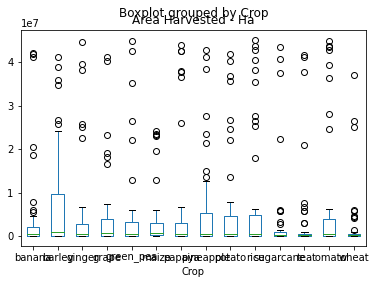

In [ ]:
train.boxplot(by ='Crop', column =['Area Harvested - Ha'], grid = False)

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


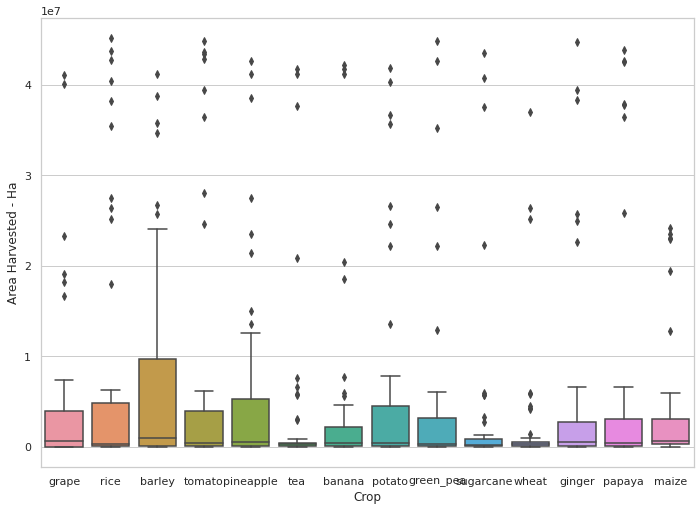

In [ ]:
sns.set_style("whitegrid")
  
sns.boxplot(x = 'Crop', y = 'Area Harvested - Ha', data = train)

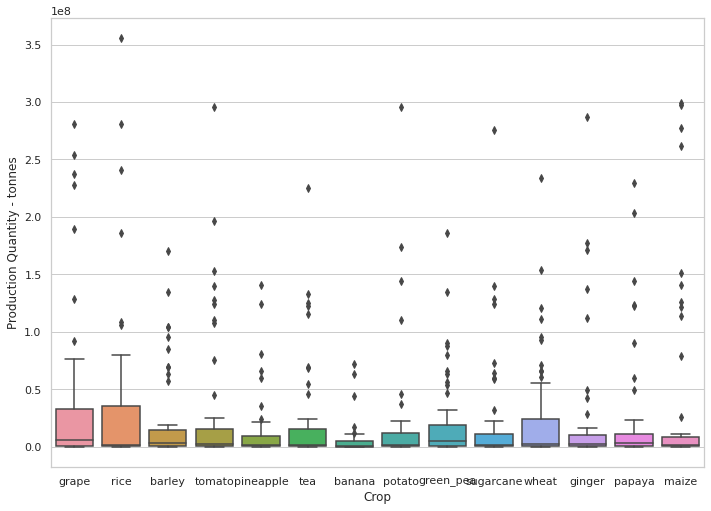

In [ ]:
sns.set_style("whitegrid")
  
sns.boxplot(x = 'Crop', y = 'Production Quantity - tonnes', data = train)

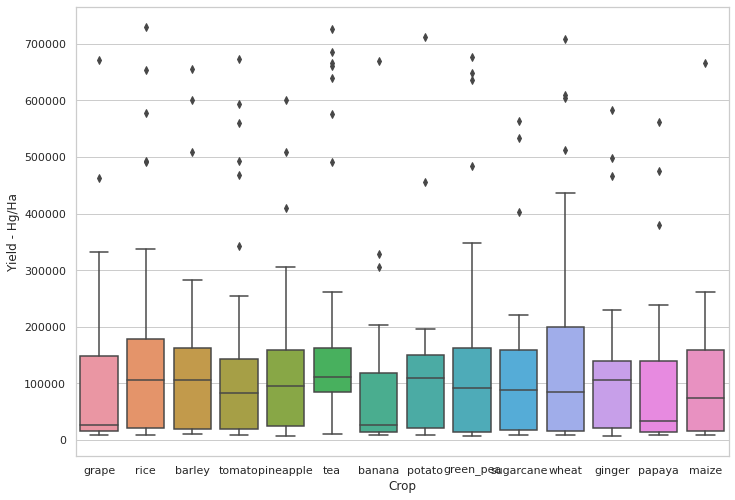

In [ ]:
sns.set_style("whitegrid")
  
sns.boxplot(x = 'Crop', y = 'Yield - Hg/Ha', data = train)

In [ ]:
df

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha
1,rice,1978,6300000,73352000,19623
2,barley,1985,70000,104225008,258628
4,pineapple,1998,12572000,246806,137248
9,banana,1980,1482800,72156200,19972
10,grape,1999,4054900,660000,16279
...,...,...,...,...,...
650,pineapple,1987,43950,59840000,142045
651,potato,1986,490000,37451808,17921
652,grape,1976,23261904,44068800,26971
654,sugarcane,2006,849000,478271,16094


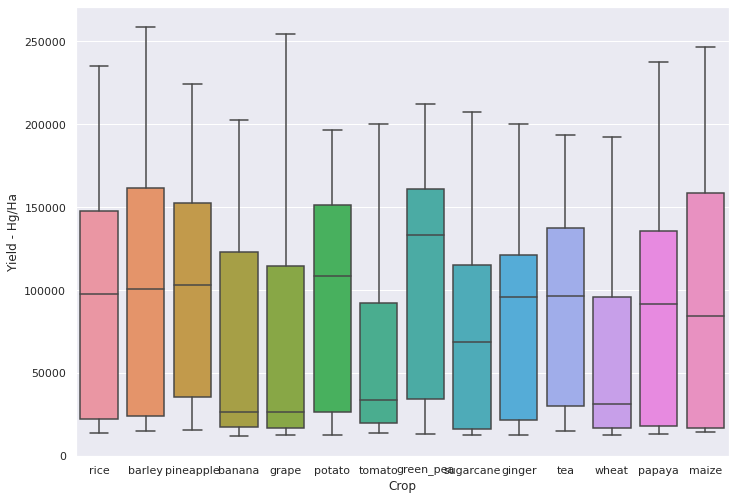

In [ ]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

  
sns.boxplot(x = 'Crop', y = 'Yield - Hg/Ha', data = df)

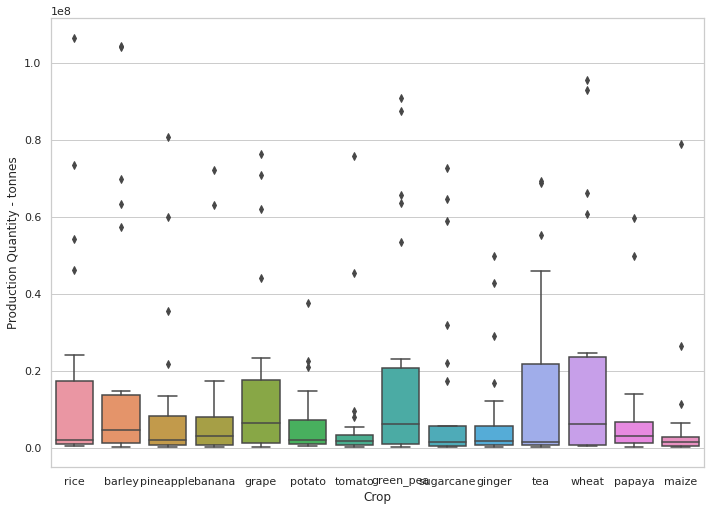

In [ ]:
sns.set_style("whitegrid")
  
sns.boxplot(x = 'Crop', y = 'Production Quantity - tonnes', data = df)

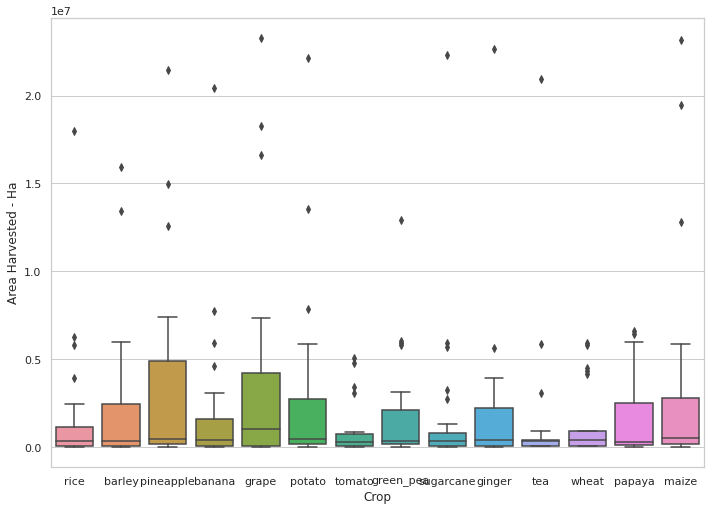

In [ ]:
sns.set_style("whitegrid")
  
sns.boxplot(x = 'Crop', y = 'Area Harvested - Ha', data = df)

In [ ]:
df2 = df[(np.abs(stats.zscore(df['Area Harvested - Ha'])) < 3)]


In [ ]:
df2

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha
1,rice,1978,6300000,73352000,19623
2,barley,1985,70000,104225008,258628
4,pineapple,1998,12572000,246806,137248
9,banana,1980,1482800,72156200,19972
10,grape,1999,4054900,660000,16279
...,...,...,...,...,...
649,potato,1983,3357600,1060000,153220
650,pineapple,1987,43950,59840000,142045
651,potato,1986,490000,37451808,17921
654,sugarcane,2006,849000,478271,16094


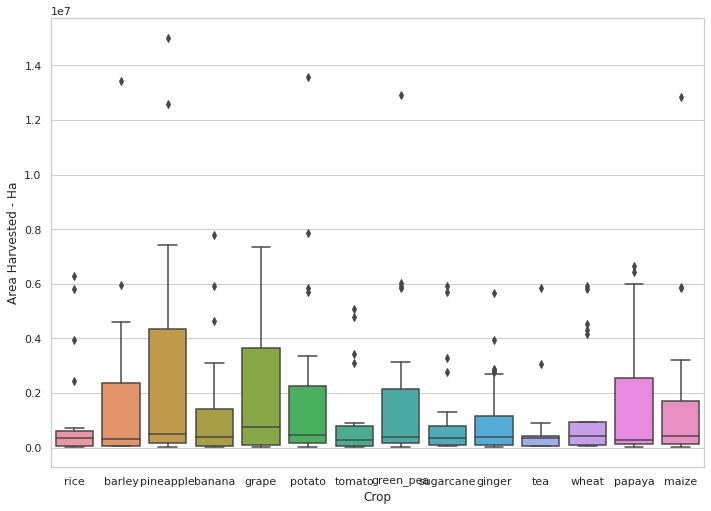

In [ ]:
sns.set_style("whitegrid")
  
sns.boxplot(x = 'Crop', y = 'Area Harvested - Ha', data = df2)

In [ ]:
df.columns

Index(['Crop', 'year', 'Area Harvested - Ha', 'Production Quantity - tonnes',
       'Yield - Hg/Ha', 'kfold', 'tar_enc_Crop'],
      dtype='object')

In [ ]:
train = pd.read_excel('/content/bhopal_data.xls')

In [ ]:
df = train.drop('Unnamed: 0',axis =1)
df["kfold"] = -1
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df)):
    df.loc[valid_indicies, "kfold"] = fold

In [ ]:
df

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold
0,grape,1993,6000,1200000,18432,1
1,rice,1978,6300000,73352000,19623,4
2,barley,1985,70000,104225008,258628,0
3,tomato,1963,434000,24734608,343061,2
4,pineapple,1998,12572000,246806,137248,4
...,...,...,...,...,...,...
653,green_pea,1988,9822,1900000,10000,0
654,sugarcane,2006,849000,478271,16094,0
655,rice,2001,5797200,24104400,222274,4
656,papaya,1973,962200,203036800,10699,0


In [ ]:
l = [ 'Area Harvested - Ha', 'Production Quantity - tonnes',
       'Yield - Hg/Ha']

In [ ]:
for i in l:
  df = df[(np.abs(stats.zscore(df[i])) < 3)]



In [ ]:
df

,Crop,year,Area Harvested - Ha,Production Quantity - tonnes,Yield - Hg/Ha,kfold
0,grape,1993,6000,1200000,18432,1
1,rice,1978,6300000,73352000,19623,4
2,barley,1985,70000,104225008,258628,0
3,tomato,1963,434000,24734608,343061,2
4,pineapple,1998,12572000,246806,137248,4
...,...,...,...,...,...,...
652,grape,1976,23261904,44068800,26971,4
653,green_pea,1988,9822,1900000,10000,0
654,sugarcane,2006,849000,478271,16094,0
655,rice,2001,5797200,24104400,222274,4


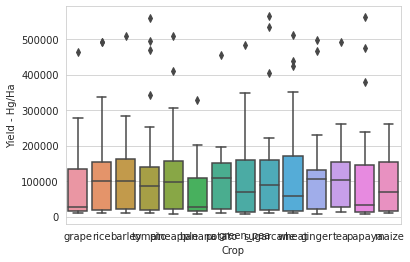

In [ ]:
sns.set_style("whitegrid")
  
sns.boxplot(x = 'Crop', y = 'Yield - Hg/Ha', data = df)

In [ ]:
lps('ababa')

5